In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt
from pyspark.sql.functions import when

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
#Load Data

bearTraining = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)
bearTesting = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)

In [6]:
#Select Features

bearTraining = bearTraining.select("Front Claws", "Pupillary Distance", "Ear Shape")

#Data Processing

bearTraining = bearTraining.na.drop()

In [7]:
#Transform Data

bearTraining = bearTraining.withColumn("Ear Shape", when(bearTraining["Ear Shape"]=="Rounded", 0).
when(bearTraining["Ear Shape"]=="Broad",1).
when(bearTraining["Ear Shape"]=="Pointed",2))

In [8]:
#Select Features

bearTesting = bearTesting.select("Front Claws", "Pupillary Distance", "Ear Shape","Grizzly")

#Data Processing

bearTesting = bearTesting.na.drop()

In [9]:
#Transform Data

bearTesting = bearTesting.withColumn(
    "Ear Shape", when(bearTesting["Ear Shape"]=="Rounded", 0).when(bearTesting["Ear Shape"]=="Broad",1)
    .when(bearTesting["Ear Shape"]=="Pointed",2))

bearTesting = bearTesting.withColumn(
    "Grizzly", when(bearTesting["Grizzly"]=="Yes",1).otherwise(0))

In [11]:
cols = bearTraining.columns
bearTraining = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(bearTraining)

In [12]:
from pyspark.ml.feature import StandardScaler

In [13]:
#Normalizaation

scaler = StandardScaler(inputCol="Vector", outputCol="features")
bearTraining = scaler.fit(bearTraining).transform(bearTraining)

In [14]:
from pyspark.ml.feature import VectorAssembler

In [15]:
cols = bearTesting.columns
cols.remove("Grizzly")
bearTesting = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(bearTesting)

In [17]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
bearTesting = scaler.fit(bearTesting).transform(bearTesting)

In [18]:
kmeans=KMeans().setK(2).setSeed(1)
model=kmeans.fit(bearTraining)

In [19]:


predictions = model.transform(bearTesting)
predictions = predictions.toPandas()

Text(0.5, 0, 'Front Claws')

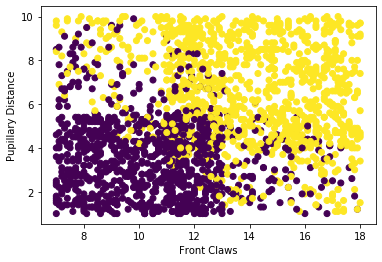

In [20]:
#Model Testing and evaluation

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Pupillary Distance"], predictions["Front Claws"], c=predictions["prediction"])

ax.set_ylabel("Pupillary Distance")
ax.set_xlabel("Front Claws")

In [21]:
count = 0
for index, row in predictions.iterrows():
	if row ["Grizzly"] == row ["prediction"]:
		count += 1

print("Accuracy: {}%".format(count / len(predictions) * 100))

Accuracy: 83.55%
